In [1]:
import h5py
from string import Template
import numpy as np
import scipy
import os
from matplotlib import pyplot as plt, cm
!pip install pyestimate
from pyestimate import sin_param_estimate

def integrate_q(data,q,q_roi, norm_sum):
    """checked by Christian"""
    q_start, q_stop = q_roi
    start_index = np.where(q>=q_start)[0][0]
    stop_index = np.where(q>=q_stop)[0][0]
    azimutal_integrated = np.sum(data[...,start_index:stop_index]*norm_sum[:,start_index:stop_index] ,axis=(2,3))
    norm = np.sum(norm_sum[:,start_index:stop_index], axis=(0,1))
    output = np.divide(azimutal_integrated ,norm , out=np.zeros_like(azimutal_integrated))
    return output

def load_data(proposal,visit,scan, det, cluster='maxiv'):
    """keys in file that will be loaded
        **FROM AZINT FILE**
        'I' : cake plot from radial integration, ordering (image,azimuthal,q) 
        'azi', : azimuthal bins
        'mask_file', : file path for mask used for radial integration
        'norm', : weights/norm sum for computing averages for integrated data, (azimuthal and q)
        'polarization_factor', : polarisation factor used for integration
        'poni_file', : file path for pony file
        'q', : q Vektor for integration
        **FROM MASTER FILE**
        'i_t', : diode data, transmittance for 2D map
        'dt' : exposure time from eiger/lambda/diode
        'title' :  scan command from SPOCK
        'swaxs_x' : swaxs_x stage position (encoder reading)
        'swaxs_y' : swaxs_y stage position (theoretical reading)
        'swaxs_rot' : swaxs_y stage position (theoretical reading)
        'time' : time point for triggers for exposure
    """
    if cluster == 'maxiv':
        fname = '/data/visitors/formax/%s/%s/process/azint/scan-%04d_%s_integrated.h5' %(proposal, visit, scan, det)
    elif cluster == 'lunarc':
        fname = '/projects/maxiv/visitors/formax/%s/%s/process/azint/scan-%04d_%s_integrated.h5' %(proposal, visit, scan, det)
    else:
        print("Clustername is not recognised")
        
    data = {}
    items = {
         'I': 'entry/data2d/cake',
         'q': 'entry/data1d/q',
         'azi' : 'entry/data2d/azi',
         'mask_file':'entry/azint/input/mask_file',
         'norm':'entry/data2d/norm',
         'polarization_factor':'entry/azint/input/polarization_factor',
         'poni':'entry/azint/input/poni',   
    }
    with h5py.File(fname, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]  
            
    # master file
    master = fname.replace('process/azint', 'raw')
    master = master.replace('_%s_integrated' %det, '')
    items = {
        'i_t': 'entry/instrument/albaem-e01_ch1/data',   
         'title': 'entry/title'                       
    }
    with h5py.File(master, 'r') as fh:
        for key, name in items.items():
            if name in fh:
                data[key] = fh[name][()]

    # fly or step scan
    if fly_scan == True:
        data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4]))
    else:
        data['shape'] = (int((str(data['title']).split(' '))[8])+1, int((str(data['title']).split(' '))[4])+1)
    return data


Defaulting to user installation because normal site-packages is not writeable


# Parameters (to be defined by user)

In [76]:
scan = 450
proposal = 20240661
visit = 2024102408
#det = 'eiger' # Pick 'eiger' or 'lambda'
#q_range = (0.0288,0.030) # Select q_range = (q_min,q_max) for q-dependent plot
#q_range = ()

det = 'lambda'
#q_range = (1.59,1.64)
q_range = (1.70,1.80)

# Data processing

In [77]:

#Reading scan parameters
fname = '/data/visitors/formax/%s/%s/raw/scan-%04d.h5' %(proposal, visit, scan)
fh = h5py.File(fname, 'r')
title_str = str(fh['entry/title'][()]).split(' ')

if title_str[0][2:] == 'meshct_maxiv':
    fly_scan = True
else:
    fly_scan = False
        
if title_str[10][0:4] == 'True':
    snake_scan = True
else:
    snake_scan = False

    
#Loading data
data = load_data(proposal,visit,scan,det)

# absorption contrast
I = data['i_t'].reshape(data['shape'])
I_flipped = np.copy(I)
if snake_scan == True:
    I_flipped[1::2,:] = I_flipped[1::2,::-1]
absorption = I_flipped


# dark field
I = data['I'].reshape((data['shape'][0],data['shape'][1],data['azi'].shape[0],data['q'].shape[0]))

I_flipped = np.copy(I)
if snake_scan == True:
    I_flipped[1::2,:,:,:] = I_flipped[1::2,::-1,:,:]
data_scat = I_flipped
total_scattering = np.average(data_scat,axis=(2,3))

q = data['q']
norm_sum = data['norm']

#Defining q ranges for background subtraction
q_bg1 = (q_range[0]-(q_range[1]-q_range[0]),q_range[0]) 
q_bg2 = (q_range[1],q_range[1]+(q_range[1]-q_range[0])) 

ind_q = list(np.where((q>q_range[0]) & (q<q_range[1]))[0])
ind_bg1 = list(np.where((q>q_bg1[0]) & (q<q_bg1[1]))[0])
ind_bg2 = list(np.where((q>q_bg2[0]) & (q<q_bg2[1]))[0])

#print(len(ind_q))
#print(len(ind_bg1))
#print(len(ind_bg2))

# q dependent, background subtracted
image = integrate_q(data_scat,q,q_range,norm_sum)  - 0.5*((len(ind_q)/len(ind_bg1))*integrate_q(data_scat,q,q_bg1,norm_sum) + (len(ind_q)/len(ind_bg2))*integrate_q(data_scat,q,q_bg2,norm_sum))


# Plotting

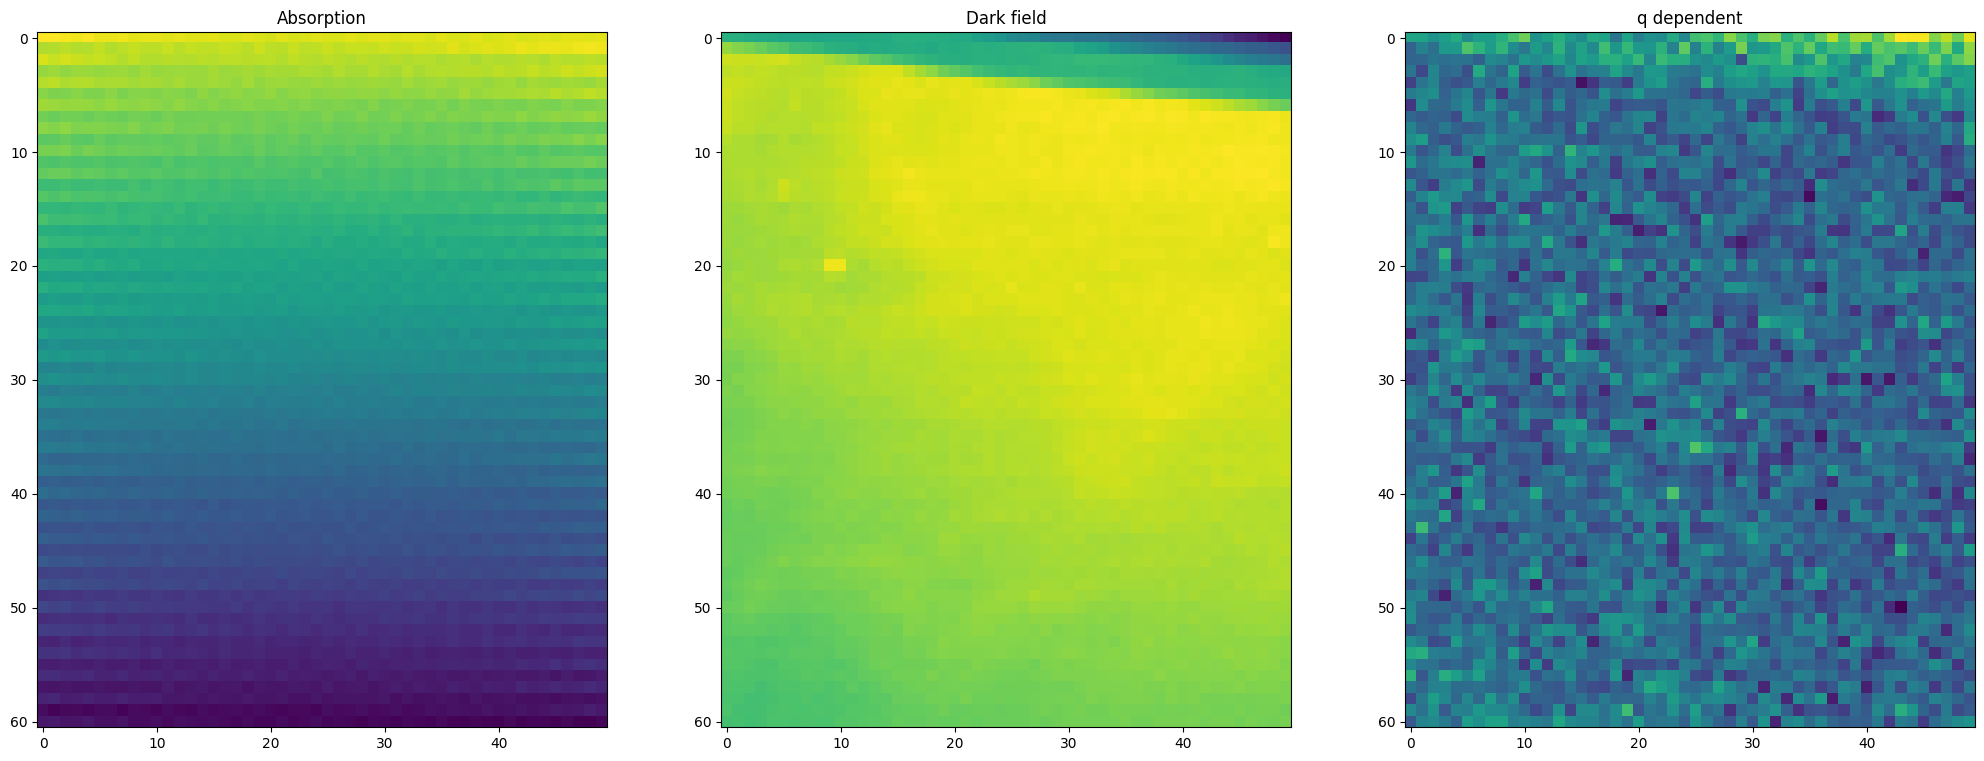

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,10))

# absorption
ax1.imshow(absorption)
ax1.title.set_text('Absorption')

# dark field
ax2.imshow(total_scattering)
ax2.title.set_text('Dark field')

#q dependent
ax3.imshow(image)
ax3.title.set_text('q dependent')


# Orientation analysis

### Data processing

(1, 135)
(3050, 180)
74.75430936933829
0.19833901551413438
0.49597546331056225


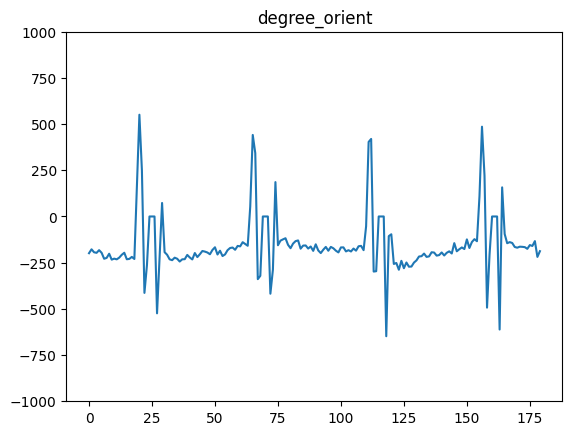

In [59]:
#Defining angular range for background fitting (to subtract gaps) 
ind_ang = np.array([np.arange(0,26)])


ind_ang1 = np.array([np.arange(0,26)])
ind_ang2 = np.array([np.arange(66,113)])
ind_ang3 = np.array([np.arange(118,180)])

ind_ang = np.concatenate((ind_ang1,ind_ang2),axis=1)
ind_ang = np.concatenate((ind_ang,ind_ang3),axis=1)
print(ind_ang.shape)

#Background subtraction and cropping
data_azi = np.sum(data_scat[:,:,:,ind_q],axis=3) - 0.5*((len(ind_q)/len(ind_bg1))*np.sum(data_scat[:,:,:,ind_bg1],axis=3)+(len(ind_q)/len(ind_bg2))*np.sum(data_scat[:,:,:,ind_bg2],axis=3)) 
data_azi = np.vstack(data_azi)
print(data_azi.shape)




A,f,phi = sin_param_estimate(data_azi[1000,:])
#A,f,phi = sin_param_estimate(data_azi[3049,:])
#A,f,phi = sin_param_estimate(data_azi[5314,:])

print(A)
print(f)
print(phi)


plt.figure()
plt.plot(data_azi[1000,:])
#plt.plot(2*ind_ang, data_azi[3049, ind_ang])
#plt.plot(data_azi[5314,:])
#plt.plot(A*np.cos(2*np.pi*n*f+phi), 'r--')
plt.title('degree_orient')
plt.ylim([-1000,1000])
plt.show()


